In [1]:
import django
import sys, os
import platform
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import numpy as np

if platform.node() == "srv-mcc-apsis":
    #sys.path.append("/home/galm/software/django/tmv/BasicBrowser/")
    sys.path.append('/home/leey/tmv/BasicBrowser/')
else:
    # local paths
    sys.path.append('/home/leey/Documents/Data/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

#import from appended path
import scoping.models as sm
import twitter.models as tm
import parliament.models as pm

from django.db.models import Sum, Count, Q
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import datetime
import random

import igraph
#import mpld3

from adjustText import adjust_text

In [2]:
# Style
import seaborn as sns
sns.set_style('whitegrid')

---

## getting data

NEW: extend data to end Feb 2020, run scores on those

In [3]:
p = sm.Project.objects.get(pk=196)

In [4]:
start_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

In [5]:
end_date = datetime.datetime.strptime('2020-03-01-+0000', '%Y-%m-%d-%z')

In [6]:
# Get tweets related to the project
searches = tm.TwitterSearch.objects.filter(project_list=p)

In [7]:
kohle_ts = tm.TwitterSearch.objects.get(pk=1)

---

### Filter for relevant keywords

filter tweets in 'Kohle' set using relevant hashtags, then add tweets from other TS objects to joint dataset

In [8]:
# Q lookup must precede any keyword argument
query1 = tm.Status.objects.filter(
    Q(text__icontains = '#klimaschutz') |
    Q(text__icontains = '#hambacherforst') |
    Q(text__icontains = '#hambibleibt') |
    Q(text__icontains = '#endcoal') |
    Q(text__icontains = '#fridaysforfuture') |
    Q(text__icontains = '#klimawandel') |
    Q(text__icontains = '#klima') |
    Q(text__icontains = '#endegelaende') 
).filter(
    searches=kohle_ts
).filter(
    created_at__gte=start_date,
    created_at__lte=end_date
)

#query1.count()

In [9]:
query2 = tm.Status.objects.filter(
    searches__in=searches,
    text__isnull=False,
    retweeted_status__isnull=True,
    created_at__gte=start_date,
    created_at__lte=end_date
)

#query2.count()

### combining tweets

In [10]:
# taking the union of both querysets
qcomb = query1 | query2

In [11]:
qcomb.count()

46352

In [12]:
qcomb_ids = set(qcomb.values_list('id',flat=True))

In [13]:
texts = tm.Status.objects.filter(
    id__in=qcomb_ids
).values_list('id','created_at','text', 'lang')

In [14]:
df_texts = pd.DataFrame(list(texts), columns=['id','created_at','text', 'lang'])

In [15]:
# getting german tweets only
is_de = df_texts["lang"]=="de"
texts_de = df_texts[is_de]

---

## Sentiment Analysis

In [16]:
import spacy
from spacy_sentiws import spaCySentiWS

nlp = spacy.load('de')
sentiws = spaCySentiWS(sentiws_path='../SentiWS')
nlp.add_pipe(sentiws)

In [17]:
def get_senti_score(tweet):
    """gets the score of a tweet from SentiWS"""
    scores = []
    for token in tweet:
        score = token._.sentiws
        if score is not None:
            scores.append(score)
    
    if sum(scores) != 0:
        return sum(scores)/len(scores)
    else:
        return 0

---

### Actual

In [20]:
texts_scores = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    doc = nlp(entry['text'])
    tweet_score = get_senti_score(doc)
    texts_scores.append(tweet_score)

In [21]:
texts_de['score'] = texts_scores

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
# return new column with date 
date_only = []
for i in texts_de.index:
    entry = texts_de.loc[i]
    entry_date = entry['created_at'].date()
    date_only.append(entry_date)

In [23]:
texts_de['date_only'] = date_only
texts_de.head()

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,id,created_at,text,lang,score,date_only
0,1178477110467481602,2019-09-30 01:10:12+00:00,@Helmut_Erhard @tagesschau Stimmt! Beide Parte...,de,0.004000,2019-09-30
1,1178477221008285698,2019-09-30 01:10:39+00:00,Stimmt! Beide Parteien sind für:\nJeder darf k...,de,0.004000,2019-09-30
2,1178544430078480384,2019-09-30 05:37:43+00:00,@DSchrombgens @inchtweet @neuthfer @ErnMedBlog...,de,0.250900,2019-09-30
3,1178545031176708096,2019-09-30 05:40:06+00:00,Im Kampf gegen den Klimawandel hat Baden-Württ...,de,-0.103075,2019-09-30
4,1178550244512063489,2019-09-30 06:00:49+00:00,Schritt für Schritt dem Ende der #Braunkohle e...,de,0.177400,2019-09-30


In [24]:
texts_de.to_csv('texts_de_20200306.csv')

---

### Results

In [25]:
# importing results from csv
texts_de_old = pd.read_csv('texts_de_20200226.csv', index_col=[0])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
# combining
texts_de_comb = pd.concat([texts_de_old, texts_de], ignore_index=True, sort=False)

In [106]:
texts_de_comb.to_csv('texts_de_comb_20200309.csv')

In [29]:
# renaming objects
texts_de_new = texts_de
texts_de = texts_de_comb

In [48]:
texts_de['date_only'] =  pd.to_datetime(texts_de['date_only'])

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
texts_de.head()

,id,created_at,text,lang,score,date_only
0,5944270614,2009-11-22 11:55:21+00:00,"Die USA bremsen #Klimaabkommen, weil sie noch ...",de,0.004000,2009-11-22
1,5978704331,2009-11-23 15:17:24+00:00,#Schottland: #Waldbesetzung gegen #Kohle-#Tage...,de,-0.340800,2009-11-23
2,6089959841,2009-11-26 19:18:40+00:00,#Klimaschutz: Eine Maßnahme hilft wirklich: Ko...,de,0.086533,2009-11-26
3,6230764335,2009-12-01 09:41:27+00:00,ak2 diskutiert Mindestwirkungsgrad bei Kohle- ...,de,0.000000,2009-12-01
4,6265364638,2009-12-02 10:05:53+00:00,#Klimawandel: im Moment haben offenbar die Pro...,de,0.000000,2009-12-02


In [32]:
len(texts_de)

236942

In [34]:
texts_de['score'].isna().sum()

62

In [36]:
# removing missing data
texts_de = texts_de.dropna(subset=['score'])
len(texts_de)

236880

In [37]:
average_score = sum(texts_de['score'])/len(texts_de['score'])
average_score

-0.02286150868036146

In [49]:
texts_de_daily_count = texts_de.groupby(pd.Grouper(key='date_only',freq='D'))['id'].count()

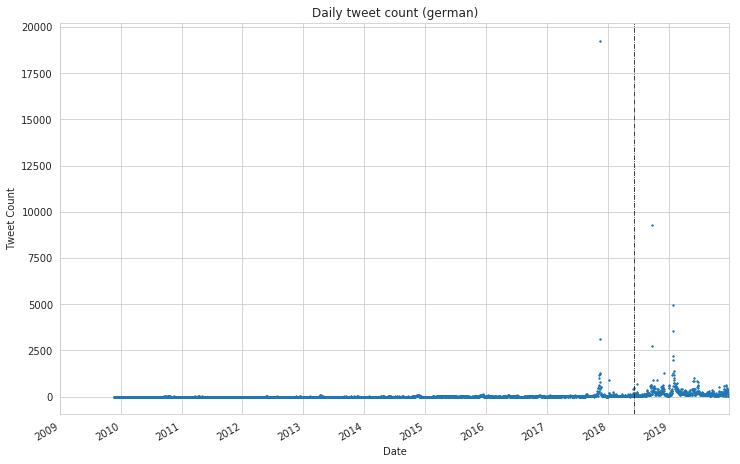

In [50]:
# tweet freq over time
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count, marker='.', s=10, edgecolor=None)
ax.set(xlim=(datetime.datetime.strptime('2009-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')),
       #ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count (german)")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

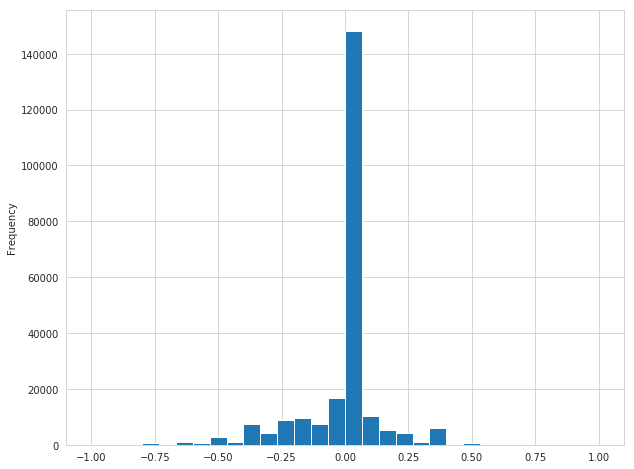

In [51]:
fig, ax = plt.subplots(figsize=(10,8))

texts_de['score'].plot.hist(bins=30)

plt.show()

In [52]:
most_neg = texts_de.sort_values(by=['score'])[0:10]
for i in most_neg.index:
    print(most_neg.loc[i]['text'])

#Klima2050 #Kohlekommission #Versorgungssicherheit - Hans-Jürgen #Brick #Amprion - „laufen schon ab 2020 Gefahr nationale Deckungslücke beim #Strom zu haben“ https://t.co/Sg0ZDoYBRs
Das Paris-Abkommen ist in Gefahr: Seit Jahren wird die Debatte um den klimapolitisch notwendigen Kohleausstieg Deu… https://t.co/HXnpybU8CR
"Das #Paris-Abkommen ist in Gefahr

Seit Jahren wird die Debatte um den klimapolitisch notwendigen #Kohleausstieg... https://t.co/QwpT0nPd5e
#Klimaschutz und #Braunkohle geht nicht? Geht doch. Die #Klimaziele sind auch durch einen späteren #Kohleausstieg nicht in Gefahr, liebe @GrueneBundestag  #CO2Reduktion @Die_Gruenen https://t.co/hxtDcj0u0t
Milliardenkosten durch #Kohlestrom - Atlas analysiert Gefahren #BUND #HeinrichBöllStiftung #Kohleausstieg http://t.co/9WLZEEh9h1
#Arbeitsplätze werden oft als #Totschlagargument beim #Kohleausstieg verwendet. Dabei sind auch Jobs bei den #Erneuerbaren in Gefahr - sogar deutlich mehr. 

Wir können uns entschieden, ob Menschen in Z

In [53]:
most_pos = texts_de.sort_values(by=['score'], ascending=False)[0:10]
for i in most_pos.index:
    print(most_pos.loc[i]['text'])

#Karlsruhe tanzt für den #Kohleausstieg! Was für ein Gelungener Tag. #EndeGelaende #hambibleibt! @Ende__Gelaende… https://t.co/C7UVV3JqwO
Was für eine gelungene Aktion von @robin_wood und @Ende__Gelaende bzw. @Kokolores_SW am Kohlekraftwerk in Karlsruhe am Hafen. Laut Angaben von EnBW dürfen die AktivistInnen das Gelände bis 17Uhr verlassen ohne ihre Personalien abgeben zu müssen.
#EndeGelaende #Kohleausstieg https://t.co/gW6mLEf62w
Bus bringt Aktivisten @Ende__Gelaende nach gelungener #Kohle-Blockade jetzt nach Aussage @Polizei_NRW_AC zum #klimacamp #EndCoal
Vielen Dank an die Initiatoren und dessen Veranstaltungsteam zur gelungenen Demonstration: Tempo machen beim Kohleausstieg! https://t.co/36kT1xSajy
Hat wirklich jemand geglaubt, #Merkel und ihre Gurkentruppe bekommen etwas auf die Reihe? Das einzige, was #CDU #CSU #SPD perfekt beherrschen, ist die Ausplünderung der #Steuerzahler. #Europawahl #Kohleausstieg #ltwbb19 #ltwsn19 #ltwth19 #hbwahl19 https://t.co/TEQNt1P05c
Nüchtern betra

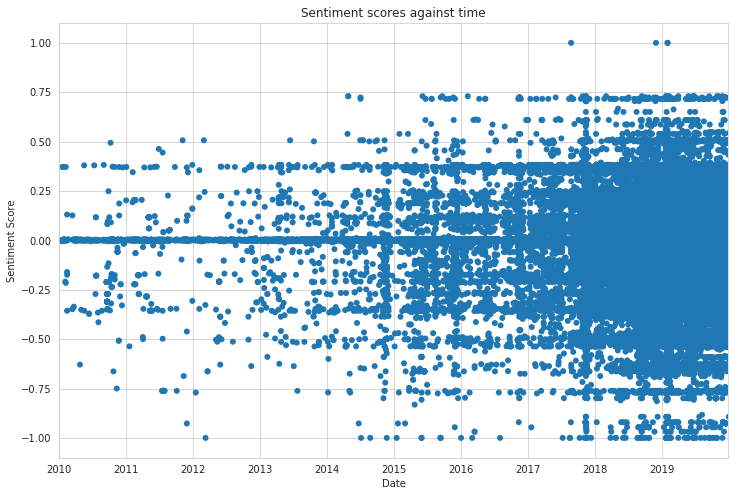

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de['date_only'], texts_de['score'], edgecolor='', ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2010-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-12-31', '%Y-%m-%d')), xlabel="Date",ylabel="Sentiment Score", title="Sentiment scores against time")
plt.show()

In [56]:
texts_de_daily = texts_de.groupby(pd.Grouper(key='date_only',freq='D'))['score'].mean()

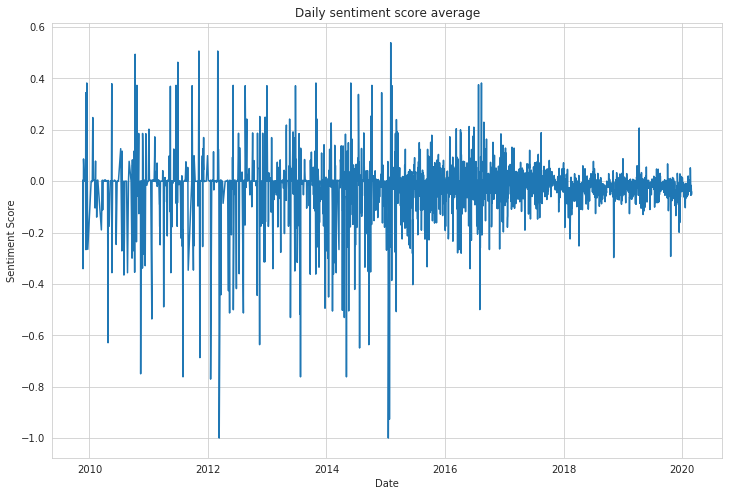

In [107]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


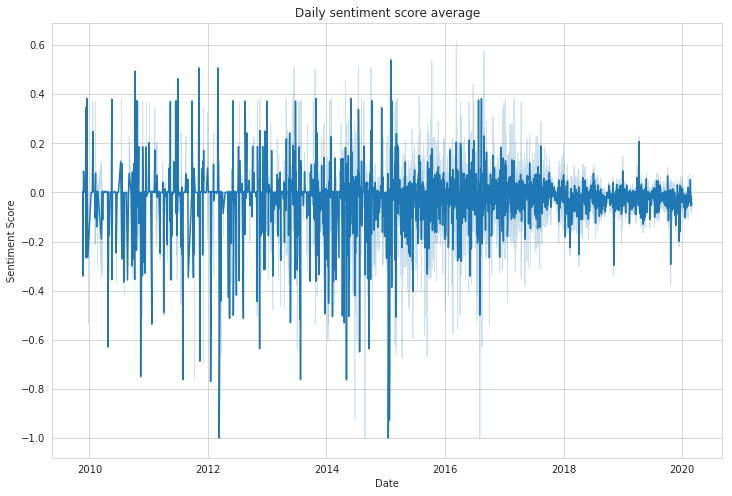

In [64]:
# average with variation
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot('date_only', 'score', data = texts_de, ax = ax)
ax.set(xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()

In [58]:
texts_de_monthly = texts_de.groupby(pd.Grouper(key='date_only',freq='M'))['score'].mean()

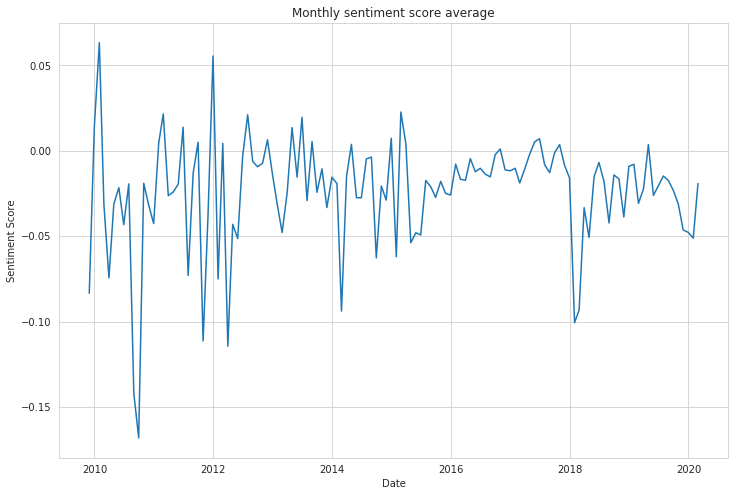

In [59]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_monthly.index, texts_de_monthly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Monthly sentiment score average")
plt.show()
#fig.savefig('plots/monthlyavgsenti.png', dpi=300)

In [60]:
texts_de_yearly = texts_de.groupby(pd.Grouper(key='date_only',freq='Y'))['score'].mean()

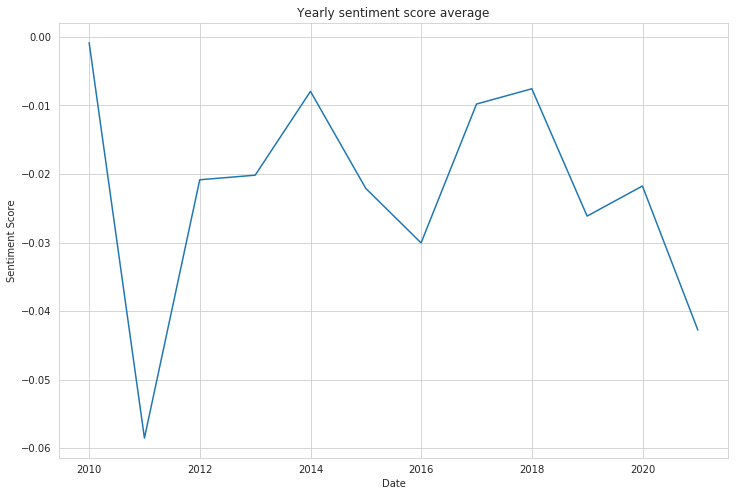

In [61]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_yearly.index, texts_de_yearly, ax = ax)
ax.set(xlabel="Date",ylabel="Sentiment Score", title="Yearly sentiment score average")
plt.show()
#fig.savefig('plots/yearlyavgsenti.png', dpi=300)

### A Closer Look

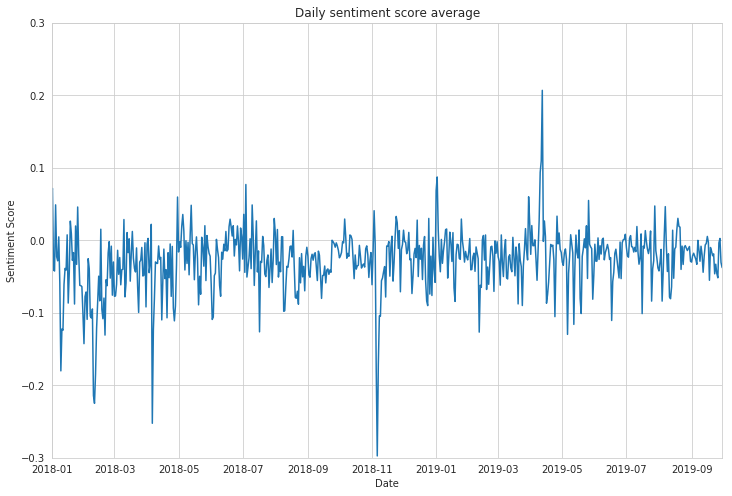

In [91]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.3,0.3),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

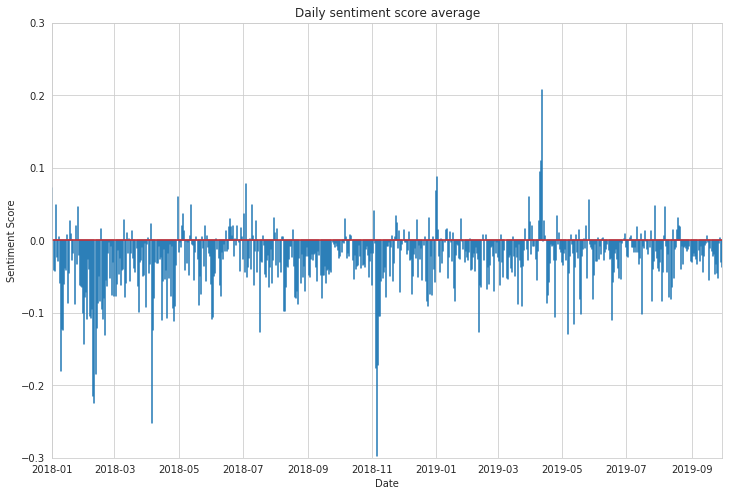

In [92]:
fig, ax = plt.subplots(figsize=(12,8))
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')),
       ylim=(-0.3,0.3),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
plt.show()
#fig.savefig('plots/dailyavgsenti.png', dpi=300)

In [96]:
#start_date = datetime.datetime.strptime('2018-01-01-+0000', '%Y-%m-%d-%z')
#end_date = datetime.datetime.strptime('2019-09-30-+0000', '%Y-%m-%d-%z')

start_date = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2019-09-30', '%Y-%m-%d')

In [97]:
date_range = (texts_de_daily.index >= start_date) & (texts_de_daily.index <= end_date)

In [98]:
texts_de_daily[date_range].sort_values(ascending=False)[:10]

date_only
2019-04-12    0.206995
2019-04-11    0.109590
2019-04-10    0.093941
2019-01-02    0.087450
2018-07-04    0.077070
2018-01-01    0.071618
2019-01-01    0.068625
2019-03-30    0.060091
2018-04-30    0.059780
2019-05-26    0.055057
Name: score, dtype: float64

In [99]:
texts_de_daily[date_range].sort_values()[:10]

date_only
2018-11-06   -0.297417
2018-04-06   -0.252404
2018-02-10   -0.224872
2018-02-09   -0.214102
2018-02-11   -0.184281
2018-01-09   -0.180069
2018-11-05   -0.175761
2018-11-07   -0.171694
2018-01-31   -0.142525
2018-02-20   -0.130702
Name: score, dtype: float64

In [100]:
positive_day = texts_de['date_only'] == datetime.date(2019,4,12)
positive_day_tweets = texts_de[positive_day]

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [101]:
positive_day_tweets.sort_values(by='score', ascending=False)[:20]

,id,created_at,text,lang,score,date_only
159868,1116706328347598849,2019-04-12 14:15:10+00:00,RT @julia_verlinden: Großartig!👍\n#DieAnstalt ...,de,0.4606,2019-04-12
159891,1116746240664973314,2019-04-12 16:53:46+00:00,@OldTomBom @DaniBrodesser @JoanHoban Eine brei...,de,0.3716,2019-04-12
159852,1116688930756341760,2019-04-12 13:06:02+00:00,Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es...,de,0.3716,2019-04-12
159721,1116590583479275522,2019-04-12 06:35:15+00:00,Guten Morgen! Heute bei @dpa_Ost: BER und die ...,de,0.3716,2019-04-12
159923,1116851597613707265,2019-04-12 23:52:25+00:00,RT @AStipicic: Sehr gut!!! #FridaysForFuture ...,de,0.3716,2019-04-12
159922,1116843257332473857,2019-04-12 23:19:17+00:00,Sehr gut!!! #FridaysForFuture #Klimawandel #...,de,0.3716,2019-04-12
159748,1116609042904784896,2019-04-12 07:48:36+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
159790,1116635658716614664,2019-04-12 09:34:21+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
159779,1116632776827129856,2019-04-12 09:22:54+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12
159781,1116633446267392005,2019-04-12 09:25:34+00:00,RT @Luisamneubauer: Was die Regierung damit sa...,de,0.3583,2019-04-12


In [102]:
most_pos_day = positive_day_tweets.sort_values(by='score', ascending=False)
for i in most_pos_day.index[:10]:
    print(most_pos_day.loc[i]['text'])

RT @julia_verlinden: Großartig!👍
#DieAnstalt im @ZDF mit "#Scheuermann" auf der Titanic, die ca 6 Grad Celsius vom Kurs nach #Paris abgekom…
@OldTomBom @DaniBrodesser @JoanHoban Eine breite gesellschaftliche Diskussion finde ich sehr gut die aber nicht bei Dieselgate und Kohleausstieg beginnt und auch dort nicht enden darf.

#Ressourcenschonung ist das Zauberwort
Heute wieder @F4F_Potsdam-Demo in #Potsdam. Es wird wieder für einen besseren Klimaschutz und einen früheren Kohleausstieg demonstriert https://t.co/OaBYIrfrki https://t.co/qCPZWoFqmg
Guten Morgen! Heute bei @dpa_Ost: BER und die Frage nach der Eröffnung / Flutung des Ostsees / Reichsbürger-Prozess in Halle / Sachsens Jugendliche und die Jugendweihe / Osterreiseverkehr / Zeitz und der Kohleausstieg /  Bühnenabschied für Gesangsduo Hauff &amp; Henkler? (mow)
RT @AStipicic: Sehr gut!!! #FridaysForFuture  #Klimawandel  #CambioClimático 
Dieses Jahr 2019 in #Chile haben #COP25 #COP25CL 
Hier sagen…
Sehr gut!!! #FridaysForFuture  #

#### @Luisamneubauer
> Was die Regierung damit sagen möchte: Da hat die Kohlekommission ein Datum auf den Tisch gelegt, was uns so gut in den Kram passt - wäre ja schön blöd nur wegen so ein paar Halbstarken auf einmal echten Klimaschutz durchzusetzen, der wohlmöglich noch dem Parisabkommen entspricht.

https://twitter.com/luisamneubauer/status/1116443797448208402

In [103]:
negative_day = texts_de['date_only'] == datetime.date(2018,11,6)
negative_day_tweets = texts_de[negative_day]

/home/leey/tmv/BasicBrowser/venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and 'the values will not compare equal to the
'datetime.date'. To retain the current behavior, convert the
'datetime.date' to a datetime with 'pd.Timestamp'.
  """Entry point for launching an IPython kernel.


In [104]:
negative_day_tweets.sort_values(by='score')[:20]

,id,created_at,text,lang,score,date_only
101664,1059951748180312065,2018-11-06 23:32:44+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101534,1059813515890962432,2018-11-06 14:23:27+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101533,1059813074675400707,2018-11-06 14:21:42+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101625,1059893706046750721,2018-11-06 19:42:06+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101519,1059797367984132096,2018-11-06 13:19:17+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101514,1059795039755399169,2018-11-06 13:10:02+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101510,1059788994479820800,2018-11-06 12:46:00+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101507,1059787821920206855,2018-11-06 12:41:21+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101500,1059784115610939392,2018-11-06 12:26:37+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06
101640,1059920115607765003,2018-11-06 21:27:02+00:00,"RT @ARTEre: Kohle oder Wald, Arbeitsplätze ode...",de,-0.6632,2018-11-06


In [105]:
most_neg_day = negative_day_tweets.sort_values(by='score')
for i in most_neg_day.index[:10]:
    print(most_neg_day.loc[i]['text'])

RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz…
RT @ARTEre: Kohle od

#### @ARTE:Re:
> Kohle oder Wald, Arbeitsplätze oder Umwelt – am Streit um den #HambacherForst Forst offenbart sich, dass das Thema Klimaschutz immer emotionaler wird. ➡️ http://bit.ly/2AAXTvX #hambi #HambiGehtWeiter 

https://twitter.com/ARTEre/status/1059740775188234240

---

## Looking at specific events

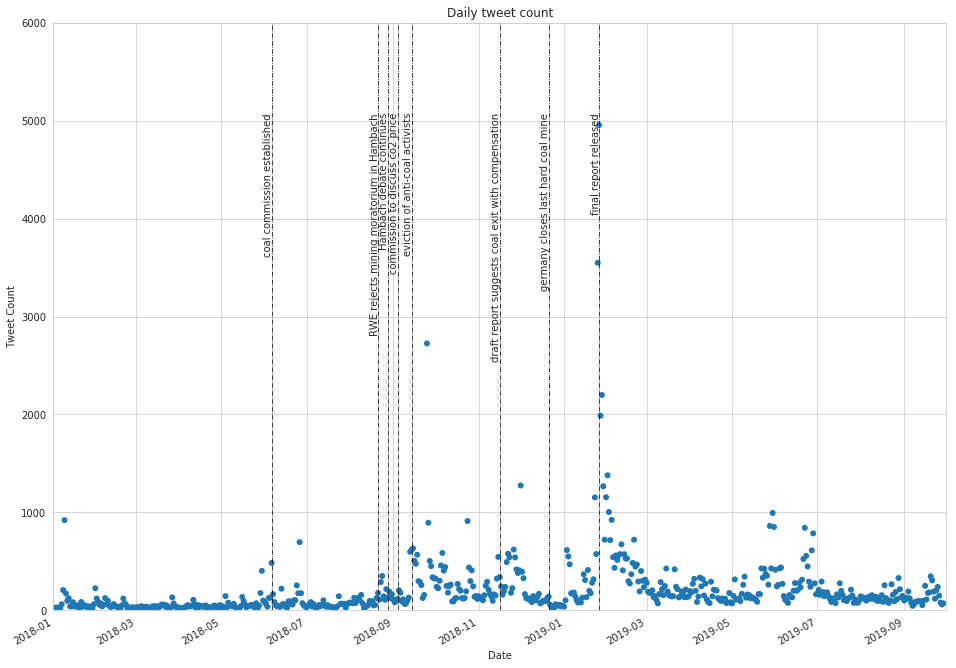

In [132]:
# overall picture with all events
# tweet freq
fig, ax = plt.subplots(figsize=(16,12))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count, edgecolor='')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), 
             datetime.datetime.strptime('2019-10-01', '%Y-%m-%d')),
       ylim=(0,6000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")

# adding event titles
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'coal commission established',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-08-21', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-08-21', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'RWE rejects mining moratorium in Hambach',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-08-28', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-08-28', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'Hambach debate continues',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-09-04', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-09-04', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'commission to discuss co2 price',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-09-14', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-09-14', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'eviction of anti-coal activists',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-11-16', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-11-16', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'draft report suggests coal exit with compensation',rotation=90, fontsize=10)
#ax.axvline(x=(datetime.datetime.strptime('2018-11-19', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
#plt.text((datetime.datetime.strptime('2018-11-19', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
#         'eastern coal states demand 60bn euro compensation',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-12-21', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-12-21', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'germany closes last hard coal mine',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')-datetime.timedelta(days=6)),5000,
         'final report released',rotation=90, fontsize=10)

fig.autofmt_xdate()
plt.show()
fig.savefig('plots/tweet_count_event_timeline.png', dpi=300)

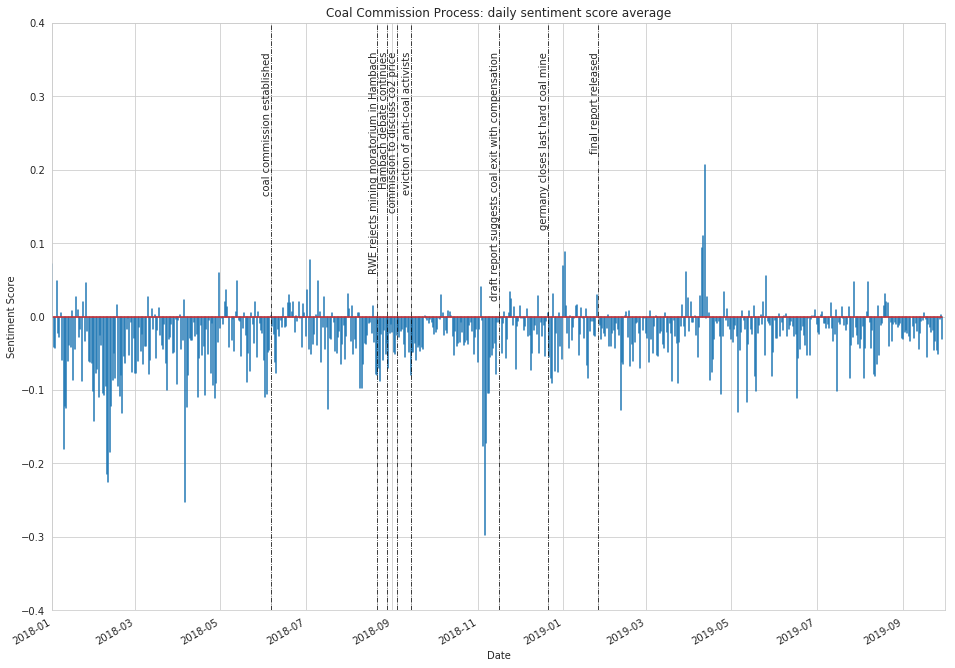

In [130]:
# overall picture with all events
# sentiment scores
fig, ax = plt.subplots(figsize=(16,12))
#sns.scatterplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-01-01', '%Y-%m-%d'), 
             datetime.datetime.strptime('2019-10-01', '%Y-%m-%d')),
       ylim=(-0.4,0.4),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Coal Commission Process: daily sentiment score average")

# adding event titles
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'coal commission established',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-08-21', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-08-21', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'RWE rejects mining moratorium in Hambach',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-08-28', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-08-28', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'Hambach debate continues',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-09-04', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-09-04', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'commission to discuss co2 price',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-09-14', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-09-14', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'eviction of anti-coal activists',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-11-16', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-11-16', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'draft report suggests coal exit with compensation',rotation=90, fontsize=10)
#ax.axvline(x=(datetime.datetime.strptime('2018-11-19', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
#plt.text((datetime.datetime.strptime('2018-11-19', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
#         'eastern coal states demand 60bn euro compensation',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2018-12-21', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2018-12-21', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'germany closes last hard coal mine',rotation=90, fontsize=10)
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
plt.text((datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')-datetime.timedelta(days=6)),0.35,
         'final report released',rotation=90, fontsize=10)

fig.autofmt_xdate()
plt.show()
#fig.savefig('plots/tweet_score_event_timeline.png', dpi=300)

### Launch of coal commission 2018-06-06

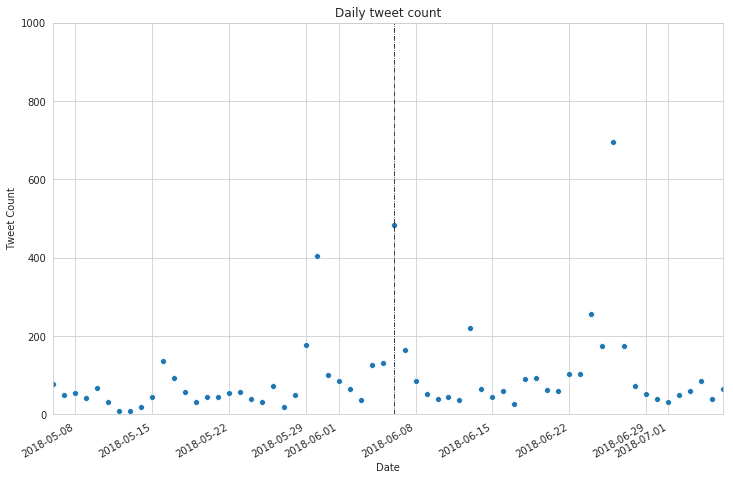

In [56]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), 
             datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(0,1000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

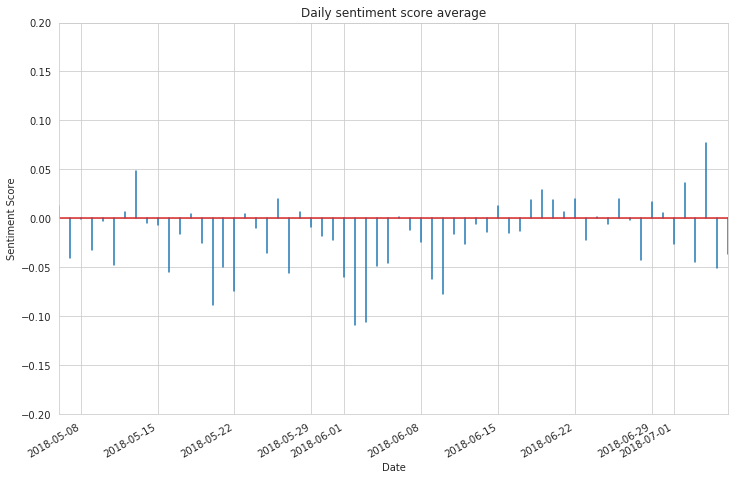

In [57]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-05-06', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-06', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
#ax.axvline(x=(datetime.datetime.strptime('2018-06-06', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

In [58]:
# tweets 
event1 = texts_de['date_only'] == datetime.date(2018,6,6)
event1_tweets = texts_de[event1]

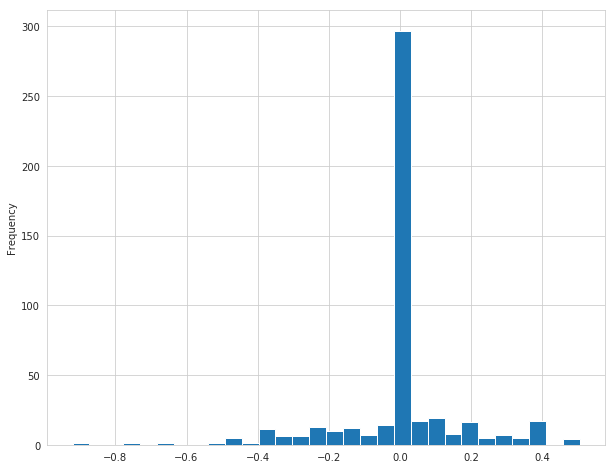

In [59]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event1_tweets['score'].plot.hist(bins=30)

plt.show()

In [60]:
event1_pos = event1_tweets.sort_values(by='score', ascending=False)
for i in event1_pos.index[:10]:
    print(event1_pos.loc[i]['text'])

Piratenpartei RT piratenparteibb: Ganz tolle Besetzung bei der Kohlekommission. Das wird wohl darauf hinaus laufen, dass noch der letzte Euro aus den Tagebauen gebuddelt wird und die Allgemeinheit dann auf den Renaturierungskosten mit einer zusammen brec… https://t.co/f2AFPL001K
Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/3369hC4Bt3
📋 Kohlekommission sollte mit Ruhe und Sorgfalt agieren https://t.co/cgt6iejaFq ❚DIHK
@zukunft_erdgas Kohle ist ein Geschenk von Mutter Natur an den Menschen, um genutzt zu werden. Wir brauchen mehr Kohleabbau statt Kohleausstieg. #Kohlekommission https://t.co/ei0pjaWeAe
Heute wird die #Kohlekomission vom Bundeskabinett berufen. Mut zur Lücke braucht sie sicherlich nicht 😉 Denn bei aktuellem Trend würde die Lücke zu unseren #Klimaschutz-Zielen von alleine immer größer.  Mut zum #Kohleausstieg! https://t.co/L7dTcmPjCI
Gleichzeitig müssen Perspektiven für Regionen geschaffen werden, wo die Kohleindustrie wichtigster Arbeitgeber ist. Kohle

In [61]:
event1_neg = event1_tweets.sort_values(by='score')
for i in event1_neg.index[:10]:
    print(event1_neg.loc[i]['text'])

Wie Kohleausstieg @DFoest ? Atomkraft ist fast weg. Was sollen wir nachts bei schwachem Wind tun? Oder von Oktober bis Februar 16-10 Uhr? https://t.co/8rPQRD3VTD
Heute Start der #Kohlekommission. Vergoldung längst geplanter Abschaltungen!! Betroffene haben kein Gewicht in WBS, müssen schlechte Entscheidungen mittragen. Was sind Roten Linien, bei denen ihr aus WBS aussteigt? @bund_net @greenpeace_de @DNR_EUnews
https://t.co/jPx7uPWJCG
Die Einsetzung einer #Kohlekommission in der keines der Worte #Kohleausstieg, #Klimaschutz oder #Energiewende im Titel vorkommen - finde den Fehler!
Bitte, @tt_embrace! Und jetzt sagen wir mit dem #RC18 der #Kanzlerin und der #Kohlekommission dem Kampf an! :) https://t.co/RmB864mL6D
#Kohlekommission Hier werden die grünen Verweigerer wieder mal zum Gutachter gemacht. Merkel vernichtet dadurch weitere Tausende Arbeitsplätze.
Wenn die #Kohlekommission sich nicht damit befasst, warum ich immer wieder zu wenig #Kohle habe, ist sie sowieso nutzlos.
Schellnhuber

### Launch of report 2019-01-26

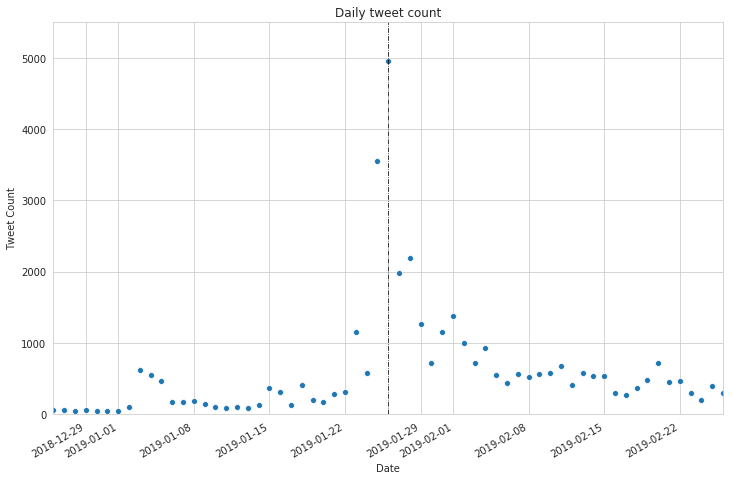

In [65]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(0,5500),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2019-01-26', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

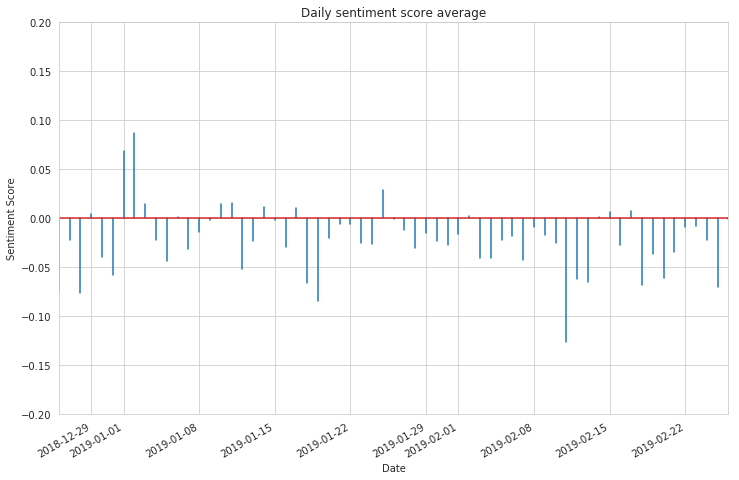

In [66]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-12-26', '%Y-%m-%d'), datetime.datetime.strptime('2019-02-26', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [67]:
# tweets 
event2 = texts_de['date_only'] == datetime.date(2019,1,26)
event2_tweets = texts_de[event2]

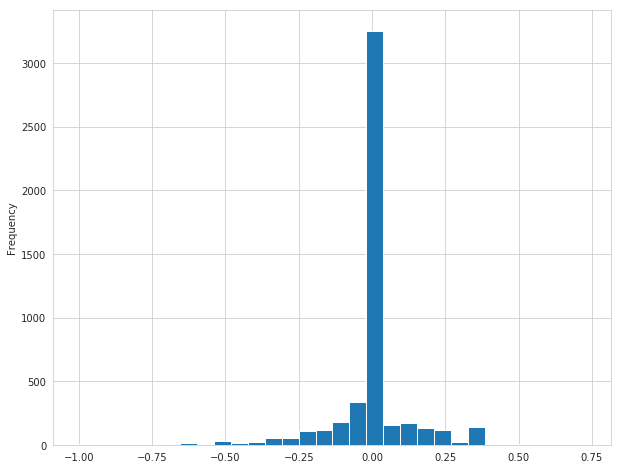

In [68]:
# spread of scores in the day
fig, ax = plt.subplots(figsize=(10,8))

event2_tweets['score'].plot.hist(bins=30)

plt.show()

In [69]:
event2_pos = event2_tweets.sort_values(by='score', ascending=False)
for i in event2_pos.index[:10]:
    print(event2_pos.loc[i]['text'])

Perfekte Idiotie! Die infantile Republik... (und diejenigen, die die Infantilität der anderen für ihre Agenda benutzen...)
#Kohleausstieg #FridaysForFuture #Kohleausstieg https://t.co/XMH2noU7A1
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUtaf9
Perfekt wäre es jetzt, wenn die Eltern nach dieser Entscheidung auch noch mit auf die Straße gehen würden #Kohlekommission
#zukunftskommission https://t.co/DPaUtUKLDJ
Ganz dickes Lob an @WDR für diesen Beitrag! #Kohlekommission #Braunkohle - 
@anettselle @wdanslesnuages @klimareport @klimacamp @ImkeByl @MonaNeubaur @bund_net @greenpeace_de @WWF_Deutschland @Ende__Gelaende  @FridayForFuture - #Energiewende muss global angegangen werden! https://t.co/WdIRCz7n3N
@rossreiter @GSiebeke @fuecks Es ist immer sehr spannend zu beobachten, wie die Menschen sich ihre Welt selber in #Ideologen und #Befürworter einteilen

"Und was ist Dein Bei

In [70]:
event2_neg = event2_tweets.sort_values(by='score')
for i in event2_neg.index[:10]:
    print(event2_neg.loc[i]['text'])

Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - Foto: Ruhrgebiet, über dts NachrichtenagenturBerlin (dts Nachrichtenagentur) - -
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/pIYw1OvNoM https://t.co/BKvJE3t34A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr
 #nachrichten
 https://t.co/HoPrQpxM4A
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/N44Gnixr88
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/du720M9Oyx https://t.co/Uf0WqlT1q3
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr https://t.co/zwaLxygYpp
Kohleausstieg: Altmaier sieht Stromversorgung nicht in Gefahr - https://t.co/eCJyXydQWb https://t.co/uHCvNBnYwz
@eysvog3l Gestern wurde in #Kohlekommission der Industriestandort 🇩🇪 von @peteraltmaier @BMWi_Bund beerdigt! 

Wer solche Arbeitervertreter wie @igbce @IGMetall Vorsitzenden &amp; seine #spd #bundestag Trulla @FahimiYasmin hat, braucht keine Feinde

### Hambach Forest debate 2018-10-05
> "Court rules clearing operations at Hambach Forest have to be stopped" - CEW

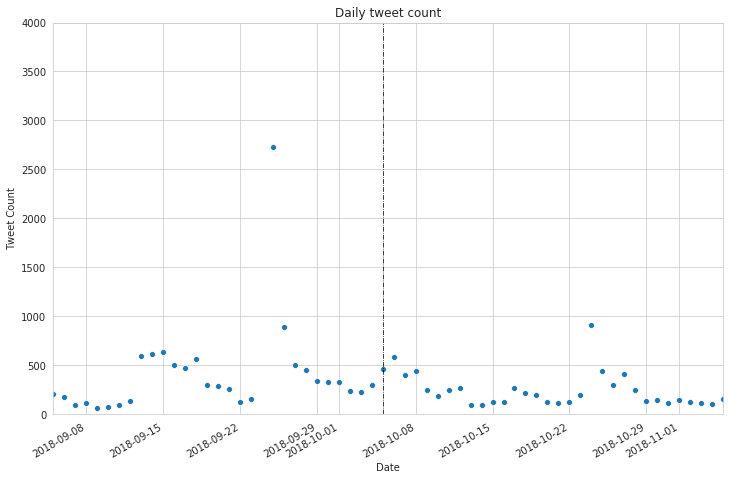

In [71]:
# tweet freq
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(texts_de_daily_count.index, texts_de_daily_count)
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(0,4000),
       xlabel="Date",
       ylabel="Tweet Count", 
       title="Daily tweet count")
ax.axvline(x=(datetime.datetime.strptime('2018-10-05', '%Y-%m-%d')), ls ='-.',lw='0.75', c = 'k')
fig.autofmt_xdate()
plt.show()

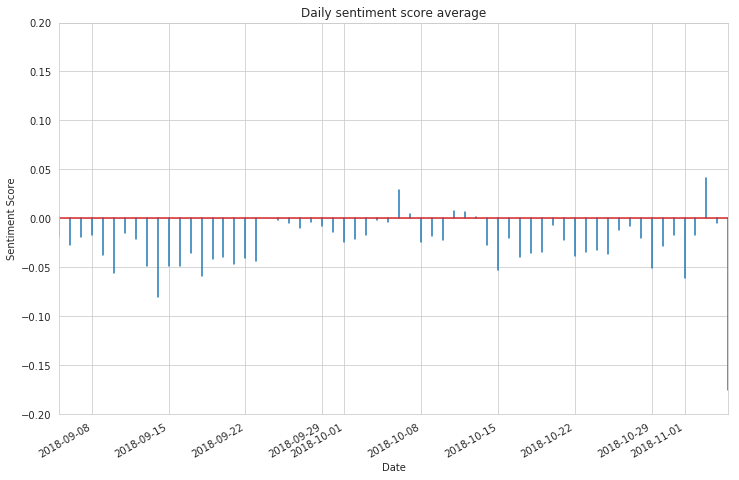

In [72]:
# sentiment scores
fig, ax = plt.subplots(figsize=(12,8))
#sns.lineplot(texts_de_daily.index, texts_de_daily, ax = ax)
ax.stem(texts_de_daily.index, texts_de_daily, markerfmt=' ')
ax.set(xlim=(datetime.datetime.strptime('2018-09-05', '%Y-%m-%d'), datetime.datetime.strptime('2018-11-05', '%Y-%m-%d')),
       ylim=(-0.2,0.2),
       xlabel="Date",
       ylabel="Sentiment Score", 
       title="Daily sentiment score average")
fig.autofmt_xdate()
plt.show()

In [73]:
# tweets 
event3 = texts_de['date_only'] == datetime.date(2018,10,5)
event3_tweets = texts_de[event3]

In [74]:
event3_pos = event3_tweets.sort_values(by='score', ascending=False)
for i in event3_pos.index[:10]:
    print(event3_pos.loc[i]['text'])

Letzter Aufruf - spannender Kinoabend heute in Kerpen bei Köln! Wir zeigen "Wackersdorf", Regisseur Oliver Haffner ist vor Ort und es gibt noch Rest-Tickets! Um Anmeldung wird gebeten! #hambi #kohlefrei @WWF_Deutschland @LichtBlick_de @AlamodeFilm https://t.co/NnVCydhEHa
Heute nur Freude – #Rodungsstopp und kein #Demonstrationsverbot @bund_net // #Bechsteinfledermaus #Fledermaus #Hambacherforst/.org #Hambibleibt #Hambach #Tagebau, #RWE #coalmining#Oaktown #Kohleausstieg #DivestCoal #endcoal #nocoal… https://t.co/923wjPmYXx https://t.co/DrDUMIYeYh
ich könnte heulen vor Freude. 
#hambibleibt #HambacherForst #fckrwe #nrwe #Kohleausstieg
https://t.co/8ZgApN1Bkp
Vorläufiger Rodungsstopp im #HambacherForst ist super, ABER eben noch nicht endgültig.
Deshalb bleibts dabei: Morgen Demo am Wald - für #Kohleausstieg und #Hambibleibt!
#Kohle #Energiewende https://t.co/tUyyZFa9n2
hey SUPER Song und super Text- könnten wir vielleicht in unser Ökumenisches-Klimapilgern-Lieder-undTexte-Buch aufnehmen:

In [75]:
event3_neg = event3_tweets.sort_values(by='score')
for i in event3_neg.index[:10]:
    print(event3_neg.loc[i]['text'])

@Richard69367829 @cem_oezdemir Du vergleichst hier Äpfel mit Birnen, das eine ist ein Privatgrundstück, welches auch nicht vom Eigentümer so verändert werden soll, dass es für die Bevölkerung schädlich ist. Das andere ein öffentlicher Wald, welcher für Klimaschädliche Kohle zerstört werden soll.
#hambibleibt
Wald oder Kohle? Streit um den Hambacher Forst | Wir diskutieren mit @ArminLaschet, @SvenjaSchulze68, @c_lindner, Anton Hofreiter, Antje Grothus und Michael Vassiliadis. #AnneWill | Sonntag 21:45 @DasErste. #HambacherForst https://t.co/NF4a9FQ8o2
Für diejenigen, die noch nicht einordnen können, dass es beim #HambacherForst  nicht nur "um ein paar Baumhäuser" und "ein Stück Urwald" geht:

Quarks - Der Streit um die Braunkohle

https://t.co/R2jjQkGqo4

#HambiBleibt
#Kohleausstieg #Klimawandel
Großdemo für den #HambacherForst in Buir verboten. Wir gehen trotzdem auf die Straße. Hier die Route der Solidemo morgen um 14 Uhr ab Richardplatz in #Berlin.
Kohle stoppen - #hambibleibt
=&gt; 